In [1]:
from pygtrie import Trie, StringTrie

In [2]:
st = StringTrie()
st

StringTrie([], separator='/')

In [3]:
st['dog'] = 1
st['dog/cat'] = 2
st['monkey'] = 3
st

StringTrie([('dog', 1), ('dog/cat', 2), ('monkey', 3)], separator='/')

In [7]:
st.longest_prefix('dog/cat')

('dog/cat': 2)

In [8]:
st.longest_prefix('dog')

('dog': 1)

## My version

In [135]:
from copy import deepcopy

from htools import ngrams, tolist
from lolviz import *

In [303]:
class TrieNode:
    
    def __init__(self, data=()):
        self.edges = {}
        self.stop_state = False
        for x in data:
            self.append(x)
        
    def append(self, seq):
        if not seq: 
            self.stop_state = True
            return
        x = seq[0]
        if x not in self.edges:
            self.edges[x] = TrieNode()
        self.edges[x].append(seq[1:])
        
    def __repr__(self):
        return f'{type(self).__name__}({list(self.edges.keys()) or ""})'

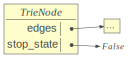

In [304]:
node = TrieNode()
objviz(node)

In [305]:
node

TrieNode()

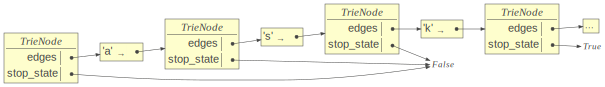

In [306]:
node.append('ask')
objviz(node)

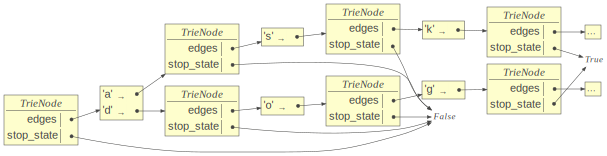

In [307]:
node.append('dog')
objviz(node)

In [308]:
node

TrieNode(['a', 'd'])

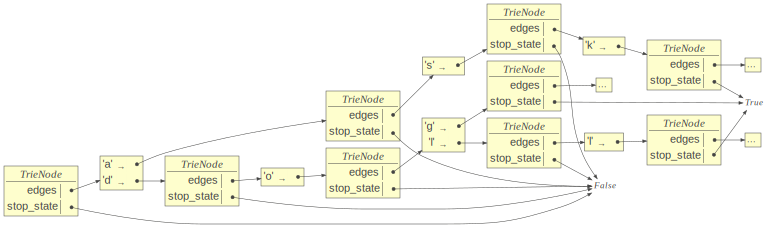

In [309]:
node.append('doll')
objviz(node)

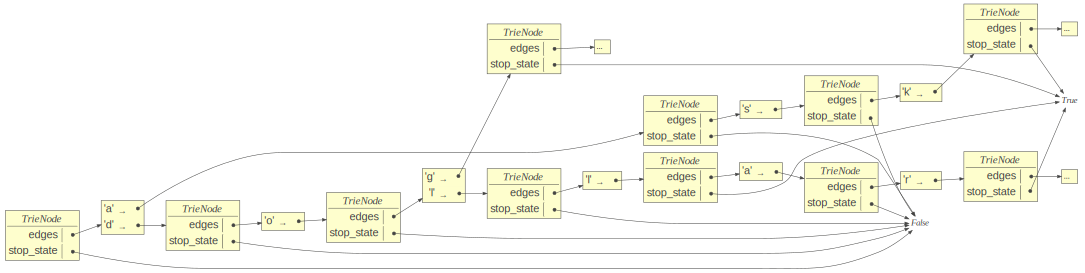

In [310]:
node.append('dollar')
objviz(node)

In [311]:
TrieNode(['dog', 'cat'])

TrieNode(['d', 'c'])

In [366]:
class Trie:
    
    def __init__(self, data=()):
        self.head = TrieNode()
        for item in tolist(data):
            self.append(item)
        
    def append(self, seq):
        self.head.append(seq)
        
    def prefixed_by(self, prefix):
        node = self.head
        seqs = set()
        for i in range(len(prefix)):
            x = prefix[i]
            node = node.edges.get(x)
            if not node: return seqs
        for k, next_node in node.edges.items():
            curr = prefix + k
            if next_node.stop_state: seqs.add(curr)
        return seqs
    
    def _traverse(self, node=None):
        for k, node_ in (node or self.head).edges.items():
            print(k)
            self._traverse(node_)
            
    def __add__(self, seq):
        clone = deepcopy(self)
        clone.append(seq)
        return clone
    
    def __contains__(self, seq):
        node = self.head
        for i, x in enumerate(seq):
            if x not in node.edges: return False
            node = node.edges[x]
        if node.stop_state: return True

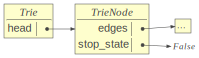

In [367]:
t = Trie()
objviz(t)

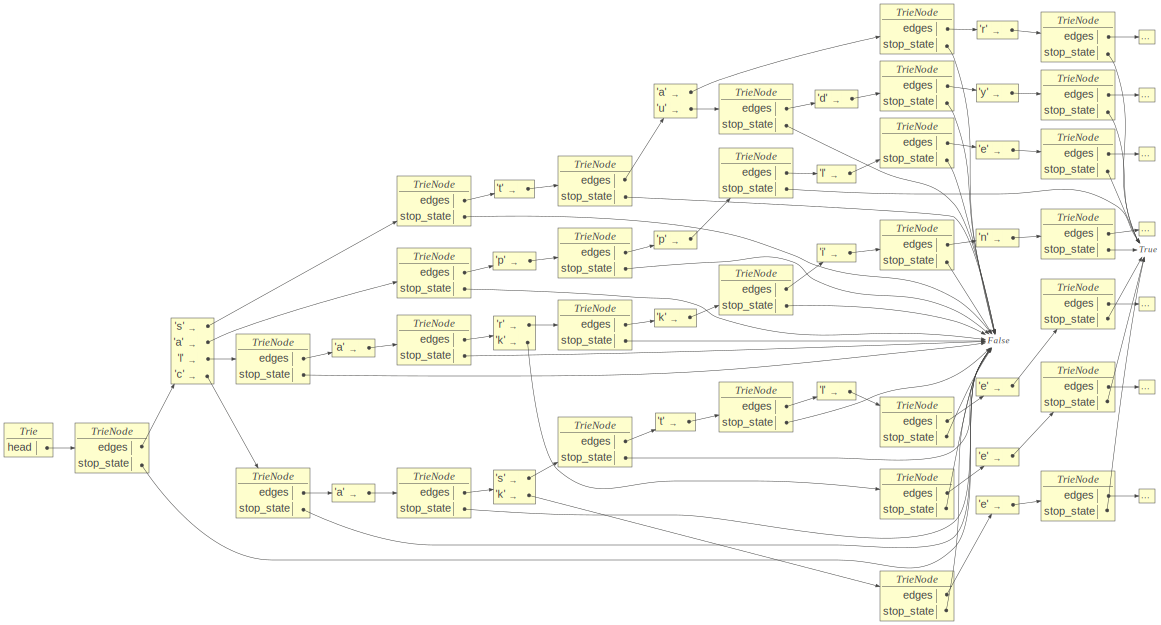

In [368]:
t.append('star')
t.append('study')
t.append('apple')
t.append('larkin')
t.append('app')
t.append('castle')
t.append('lake')
t.append('cake')

objviz(t)

In [369]:
assert 'app' in t
assert 'apple' in t
assert 'ap' not in t
assert 'appleton' not in t
assert 'fox' not in t

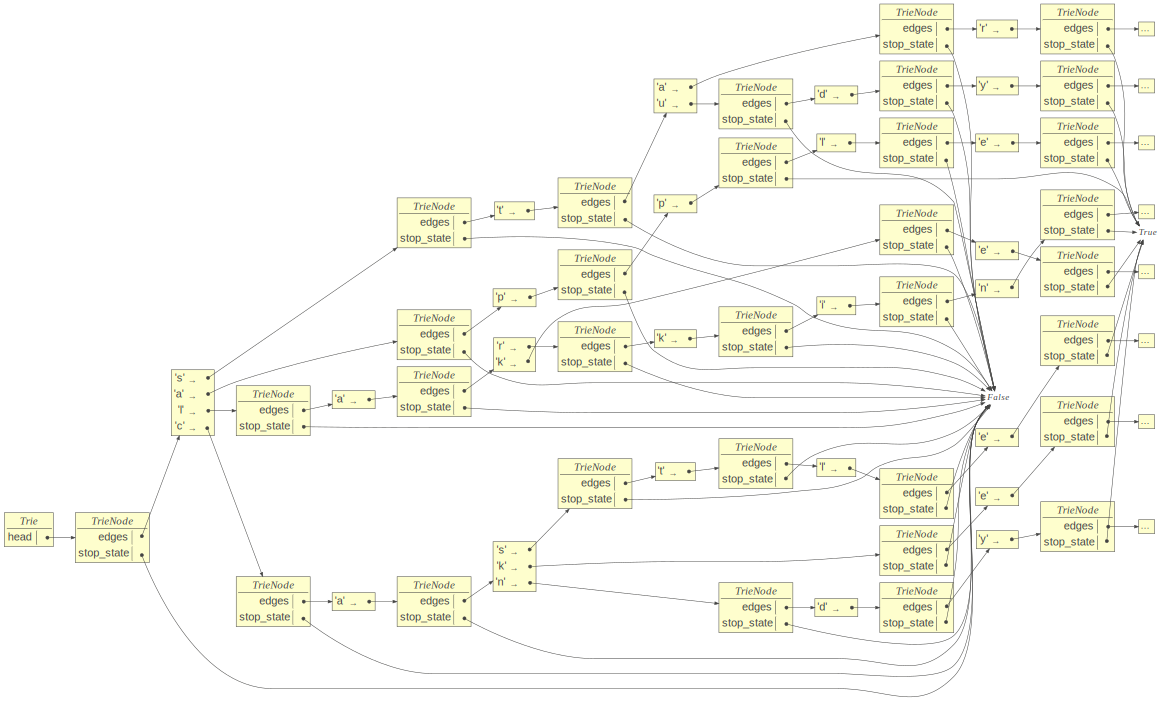

In [370]:
tmp = t + 'candy'
objviz(tmp)

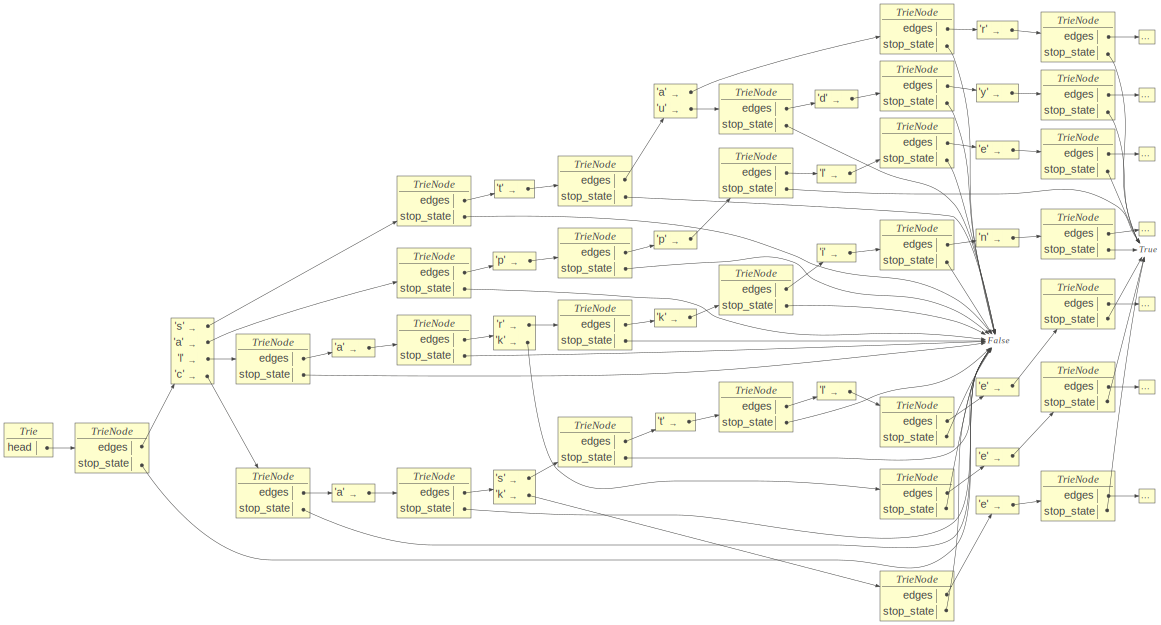

In [371]:
objviz(t)

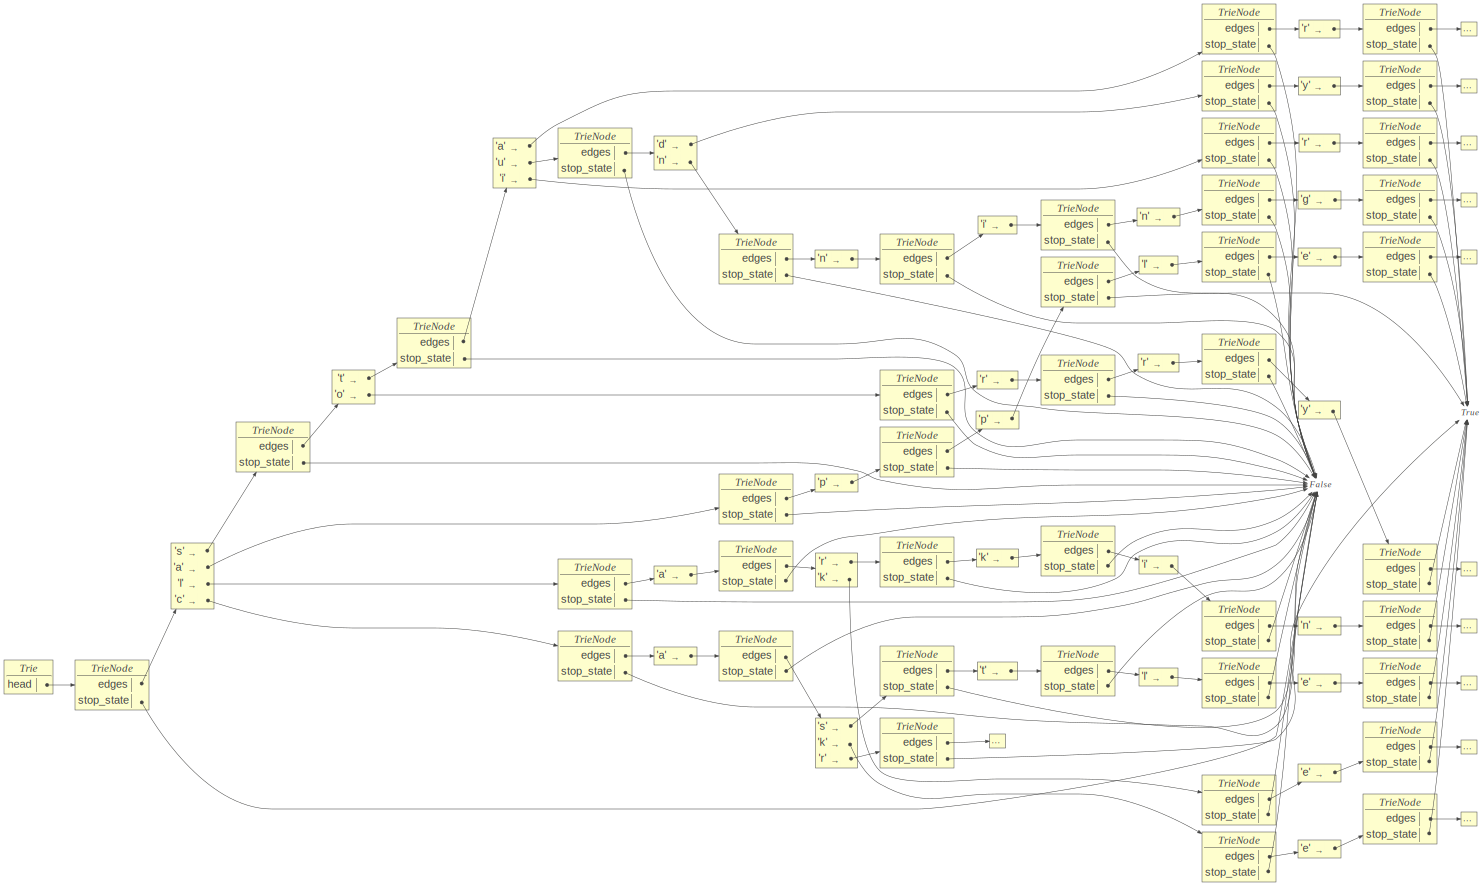

In [372]:
t += 'car'
t += 'stunning'
t += 'stir'
t += 'sorry'
objviz(t)

In [373]:
t.prefixed_by('stu')

set()

In [374]:
t._traverse()

s
t
a
r
u
d
y
n
n
i
n
g
i
r
o
r
r
y
a
p
p
l
e
l
a
r
k
i
n
k
e
c
a
s
t
l
e
k
e
r


In [485]:
# This version prints out all the words correctly but saves none of them. I 
# think this is because we pass in curr_path to _traverse so we append to the
# wrong list.
outer = []
def _traverse(node=None, path=None):
    for k, node_ in node.edges.items():
        print('k', k, 'path', path)
        curr_path = (path or []) + [k]
        if node_.stop_state: 
            outer.append(''.join(curr_path))
        _ = _traverse(node_, curr_path)
    return path

# Trying to add another var to track all paths and curr path. Not working yet though.
# def _traverse(node=None, path=None, curr_path=None):
#     path = path or []
#     for k, node_ in node.edges.items():
#         curr_path = curr_path or []
#         curr_path.append(k)
#         if node_.stop_state: 
#             print(''.join(curr_path))
#             path.append(''.join(curr_path))
#             curr_path = None
#             return path
#         _ = _traverse(node_, path, curr_path)
#     return path

# def _traverse(node=None, paths=None, curr_path=None):
#     paths = paths or []
#     curr_path = curr_path or []
#     for k, node_ in node.edges.items():
#         print('iter', k)
#         curr_path += [k]
#         if node_.stop_state: 
#             print(curr_path)
#             return ''.join(curr_path)
#         res = _traverse(node_, paths, curr_path)
# #         print('res', res)
# #         paths.append(''.join(res))
#     return paths

In [486]:
res = _traverse(t.head)

k s path None
k t path ['s']
k a path ['s', 't']
k r path ['s', 't', 'a']
k u path ['s', 't']
k d path ['s', 't', 'u']
k y path ['s', 't', 'u', 'd']
k n path ['s', 't', 'u']
k n path ['s', 't', 'u', 'n']
k i path ['s', 't', 'u', 'n', 'n']
k n path ['s', 't', 'u', 'n', 'n', 'i']
k g path ['s', 't', 'u', 'n', 'n', 'i', 'n']
k i path ['s', 't']
k r path ['s', 't', 'i']
k o path ['s']
k r path ['s', 'o']
k r path ['s', 'o', 'r']
k y path ['s', 'o', 'r', 'r']
k a path None
k p path ['a']
k p path ['a', 'p']
k l path ['a', 'p', 'p']
k e path ['a', 'p', 'p', 'l']
k l path None
k a path ['l']
k r path ['l', 'a']
k k path ['l', 'a', 'r']
k i path ['l', 'a', 'r', 'k']
k n path ['l', 'a', 'r', 'k', 'i']
k k path ['l', 'a']
k e path ['l', 'a', 'k']
k c path None
k a path ['c']
k s path ['c', 'a']
k t path ['c', 'a', 's']
k l path ['c', 'a', 's', 't']
k e path ['c', 'a', 's', 't', 'l']
k k path ['c', 'a']
k e path ['c', 'a', 'k']
k r path ['c', 'a']


In [487]:
res

In [488]:
(sorted(outer) == 
 ['app',
 'apple',
 'cake',
 'car',
 'castle',
 'lake',
 'larkin',
 'sorry',
 'star',
 'stir',
 'study',
 'stunning'])

True

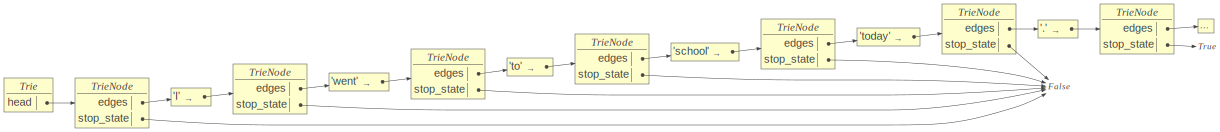

In [232]:
t2 = Trie()
t2.append(['I',  'went', 'to', 'school', 'today', '.'])
objviz(t2)

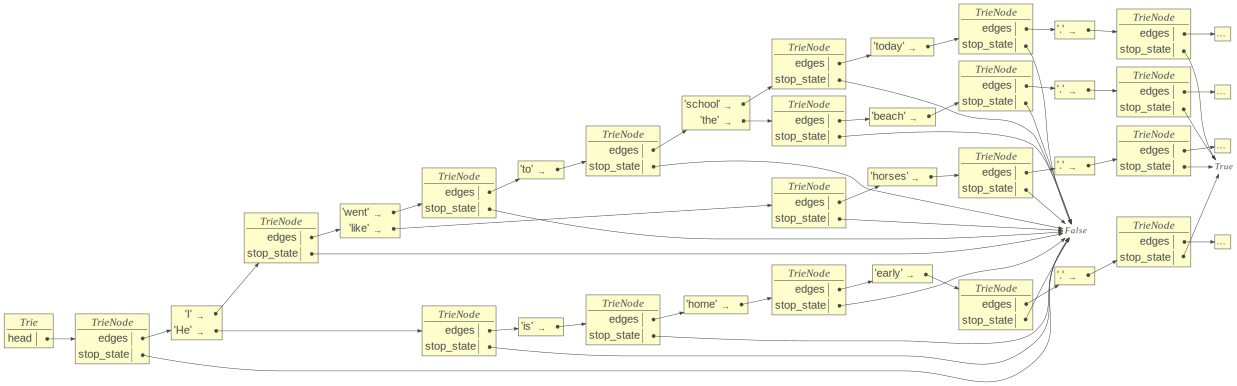

In [118]:
t2.append(['I',  'like', 'horses', '.'])
t2.append(['He', 'is', 'home', 'early', '.'])
t2.append(['I', 'went', 'to', 'the', 'beach', '.'])
objviz(t2)

In [133]:
ex = [
    'It is cold and windy.',
    'The food was still hot.',
    'It is not warm.',
    'The cow mooed loudly.',
    'It is cold and snowy.'
]

t3 = Trie()
for e in ex:
    t3.append(
        list(map(tuple, ngrams(e.split(), 2, 2, False)))
    )

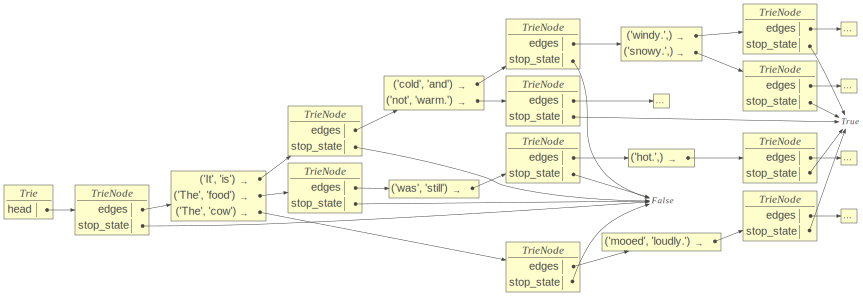

In [134]:
objviz(t3)

<class 'str'>


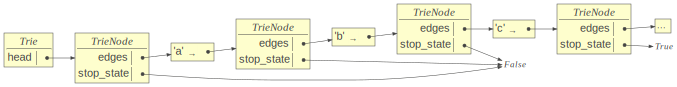

In [157]:
t4 = Trie('abc')
objviz(t4)

<class 'list'>


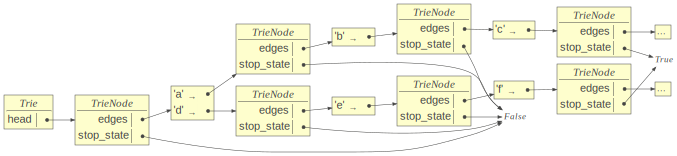

In [158]:
t5 = Trie(['abc', 'def'])
objviz(t5)